In [96]:
#Packages
!pip install keras
!pip install tensorflow
!pip install unidecode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import re
from scipy import spatial
from sklearn.manifold import TSNE
import math
import keras
import tensorflow as tf
from unidecode import unidecode
#from keras.preprocessing.text import Tokenizer

# Importation et formatage des données #

In [149]:
fichier = "data/firstname_with_sex.csv"
name_sex = pd.read_csv(fichier, sep=';')
name_sex

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951
...,...,...,...
6941,winnocq,10,0
6942,xyste,9,1
6943,zara,0,10
6944,zéraphin,10,0


In [150]:
fichier2 = "data/transcriptions_with_sex.csv"
transc = pd.read_csv(fichier2)
transc

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme
...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme


In [151]:
transc['sex'].value_counts()

sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

In [152]:
#Convert in character
transc['groundtruth'] = transc['groundtruth'].astype(str)

#We divide by ":"
split = transc['groundtruth'].str.split(":", expand=True)
split

,0,1,2,3,4,5,6,7
0,surname,Chardon firstname,Marie occupation,idem link,fille age,30,None,None
1,surname,Lhopital firstname,Louis-Jean occupation,sp link,chef age,67,None,None
2,surname,Papin firstname,Marie occupation,idem link,idem employer,idem age,15,None
3,surname,Lavocat firstname,Marie link,femme birth_date,1875 lob,Rigny,None,None
4,surname,Benne firstname,Marguerite age,78,None,None,None,None
...,...,...,...,...,...,...,...,...
236,surname,Burlurut firstname,Pétronille occupation,sans profession link,épouse age,61 ans,None,None
237,surname,Combey firstname,Alexandre occupation,idem link,son fils age,39,None,None
238,surname,Collin firstname,Marguerite occupation,idem link,épouse employer,idem age,38,None
239,surname,Dumont firstname,Etienne link,fils birth_date,1900 lob,idem,None,None


I extract column by taking the last words of the column above. I just don't take the last column because it's a value and not the name of a category. 

In [165]:
#List of columns
colonnes = ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'age', 'lob', 'civil_status', 'observation'] #I add observation because it was printed as error. 

#Creation of a dictionary
donnees = {colonne: [] for colonne in colonnes}

#Fill the dictionnary with the elements
for row in transc['groundtruth']:
    #Empty temporary dict in initialisation 
    temp = {colonne: None for colonne in colonnes}
    #Thanks to RegEx, we take expressop,s
    info = re.findall(r'(\w+): (\w+)', row)
    for colonne, valeur in info:
        # We add the corresponding value 
        temp[colonne] = valeur
    #Definitive dict
    for colonne in colonnes:
        donnees[colonne].append(temp[colonne])

# Créer un DataFrame à partir des données extraites
nouvelle_base_man = pd.DataFrame(donnees)
nouvelle_base_man 

,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation
0,Chardon,Marie,idem,fille,None,None,30,None,None,None
1,Lhopital,Louis,sp,chef,None,None,67,None,None,None
2,Papin,Marie,idem,idem,idem,None,15,None,None,None
3,Lavocat,Marie,None,femme,None,1875,None,Rigny,None,None
4,Benne,Marguerite,None,None,None,None,78,None,None,None
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans,épouse,None,None,61,None,None,None
237,Combey,Alexandre,idem,son,None,None,39,None,None,None
238,Collin,Marguerite,idem,épouse,idem,None,38,None,None,None
239,Dumont,Etienne,None,fils,None,1900,None,idem,None,None


Now, using the database about the name and the number of times they were gave to each sex, we will calculus a man proportion and a woman proportion for each name and add it to our current database. 

In [154]:
#Calculus
name_sex['prob_masc'] = name_sex['male'] / (name_sex['male'] + name_sex['female'])
name_sex['prob_fem'] = name_sex['female'] / (name_sex['male'] + name_sex['female'])
name_sex.head(50)

,firstname,male,female,prob_masc,prob_fem
0,marie,10145,2390322,0.004226,0.995774
1,jean,1869615,6476,0.996548,0.003452
2,pierre,1475841,5047,0.996592,0.003408
3,jeanne,1765,1097397,0.001606,0.998394
4,françois,1089009,5951,0.994565,0.005435
5,joseph,897742,4246,0.995293,0.004707
6,anne,1479,816241,0.001809,0.998191
7,marguerite,1441,813859,0.001767,0.998233
8,catherine,1223,792448,0.001541,0.998459
9,louis,750498,2720,0.996389,0.003611


In [155]:
def label_sex(prob_m, prob_f):
    if prob_m>=0.95:
        return 'homme'
    if prob_f>=0.95:
        return 'femme'
    else:
        return 'ambigu'

name_sex['sex'] = name_sex.apply(lambda row: label_sex(row['prob_masc'], row['prob_fem']), axis=1)
name_sex

,firstname,male,female,prob_masc,prob_fem,sex
0,marie,10145,2390322,0.004226,0.995774,femme
1,jean,1869615,6476,0.996548,0.003452,homme
2,pierre,1475841,5047,0.996592,0.003408,homme
3,jeanne,1765,1097397,0.001606,0.998394,femme
4,françois,1089009,5951,0.994565,0.005435,homme
...,...,...,...,...,...,...
6941,winnocq,10,0,1.000000,0.000000,homme
6942,xyste,9,1,0.900000,0.100000,ambigu
6943,zara,0,10,0.000000,1.000000,femme
6944,zéraphin,10,0,1.000000,0.000000,homme


In [156]:
def majo(prob_m, prob_f):
        if prob_m>= prob_f: 
            return'homme'
        else:
            return 'femme'
name_sex['majo'] = name_sex.apply(lambda row: majo(row['prob_masc'], row['prob_fem']), axis=1)
name_sex

,firstname,male,female,prob_masc,prob_fem,sex,majo
0,marie,10145,2390322,0.004226,0.995774,femme,femme
1,jean,1869615,6476,0.996548,0.003452,homme,homme
2,pierre,1475841,5047,0.996592,0.003408,homme,homme
3,jeanne,1765,1097397,0.001606,0.998394,femme,femme
4,françois,1089009,5951,0.994565,0.005435,homme,homme
...,...,...,...,...,...,...,...
6941,winnocq,10,0,1.000000,0.000000,homme,homme
6942,xyste,9,1,0.900000,0.100000,ambigu,homme
6943,zara,0,10,0.000000,1.000000,femme,femme
6944,zéraphin,10,0,1.000000,0.000000,homme,homme


In [167]:
#We convert firstname in both column without accent and capital letters (We choose first name because we trust more manual recolt) 
name_sex['firstname'] = name_sex['firstname'].astype(str)
name_sex['firstname'] = name_sex['firstname'].apply(lambda x: unidecode(x).lower()) 
df_def['firstname'] = df_def['firstname'].apply(lambda x: unidecode(x).lower() if pd.notna(x) else x)
df_def = df_def[df_def['sex'] != 'ambigu']
df_def

,nom,prénom,date_naissance,lieux_naissance,relation,employeur,subject_line,surname,firstname,occupation,...,employer,birth_date,age,lob,civil_status,observation,sex,prob_masc,prob_fem,majo
0,Chardon,Marie,30,None,None,None,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,Chardon,marie,idem,...,None,None,30,None,None,None,femme,0.004226,0.995774,femme
1,Lhopital,Louis,67,Sn,None,ahef,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,Lhopital,louis,sp,...,None,None,67,None,None,None,homme,0.996389,0.003611,homme
2,Pyrin,Marie,55,None,d,None,e6a279da-9b6f-4f49-b498-64857bc50d1e,Papin,marie,idem,...,idem,None,15,None,None,None,femme,0.004226,0.995774,femme
3,Lavocat,Marie,1875,Rigny,None,None,7534deca-39e8-4f00-be17-c12460015de1,Lavocat,marie,None,...,None,1875,None,Rigny,None,None,femme,0.004226,0.995774,femme
4,Benne,Marguerite,78,id,None,None,ef334a66-a504-418a-9872-e7c9db923488,Benne,marguerite,None,...,None,None,78,None,None,None,femme,0.001767,0.998233,femme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Gihromille,61,épouse,sans,None,1d92738a-cffe-4aee-ab10-db04c37f7405,Burlurut,petronille,sans,...,None,None,61,None,None,None,femme,0.002291,0.997709,femme
237,Comberf,Alexandre,59,d,par,None,09440055-7972-4135-a537-e6c5a1f2aeb2,Combey,alexandre,idem,...,None,None,39,None,None,None,homme,0.995444,0.004556,homme
238,Collin,Marguerite,38,None,None,None,4d387278-12c3-410c-bdf0-c5c603479764,Collin,marguerite,idem,...,idem,None,38,None,None,None,femme,0.001767,0.998233,femme
239,Dumont,Etienne,1900,id,None,None,623b95de-f87c-4844-a7f7-361088eed83a,Dumont,etienne,None,...,None,1900,None,idem,None,None,homme,0.995768,0.004232,homme


In [168]:
name_sex_unique = name_sex.drop_duplicates(subset=['firstname'])
probabilities = name_sex_unique.set_index('firstname').to_dict(orient='index')

# We assocy each probability with map
df_def['prob_masc'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_masc'] if x in probabilities else None)
df_def['prob_fem'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_fem'] if x in probabilities else None)
df_def['majo'] = df_def['sex']

/tmp/ipykernel_262/3254896628.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_def['prob_masc'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_masc'] if x in probabilities else None)
/tmp/ipykernel_262/3254896628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_def['prob_fem'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_fem'] if x in probabilities else None)
/tmp/ipykernel_262/3254896628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [169]:
df = df_def.drop(['nom', 'surname', 'date_naissance', 'lieux_naissance',  'subject_line','birth_date', 'age', 'lob'], axis=1)

In [170]:
name_sex

,firstname,male,female,prob_masc,prob_fem,sex,majo
0,marie,10145,2390322,0.004226,0.995774,femme,femme
1,jean,1869615,6476,0.996548,0.003452,homme,homme
2,pierre,1475841,5047,0.996592,0.003408,homme,homme
3,jeanne,1765,1097397,0.001606,0.998394,femme,femme
4,francois,1089009,5951,0.994565,0.005435,homme,homme
...,...,...,...,...,...,...,...
6941,winnocq,10,0,1.000000,0.000000,homme,homme
6942,xyste,9,1,0.900000,0.100000,ambigu,homme
6943,zara,0,10,0.000000,1.000000,femme,femme
6944,zeraphin,10,0,1.000000,0.000000,homme,homme


In [176]:
#We add the value of names that are not in firstname 
name_sex_joint = name_sex.drop(['male', 'female'], axis=1)

common_cols = df.columns.intersection(name_sex_joint.columns)
extra_cols = name_sex_joint.columns.difference(df.columns)
extra_df = pd.DataFrame(None, index=name_sex_joint.index, columns=extra_cols)

# Filtrer les lignes de name_sex où 'firstname' n'existe pas déjà dans df
filtered_name_sex = name_sex_joint[~name_sex_joint['firstname'].isin(df['firstname'])]

# Concaténer les DataFrames filtered_name_sex et merged_df
final_df = pd.concat([filtered_name_sex, df])

# Réinitialiser les index
final_df.reset_index(drop=True, inplace=True)

final_df

,firstname,prob_masc,prob_fem,sex,majo,occupation,link,employer,civil_status,observation
0,dominique,0.931546,0.068454,ambigu,homme,NaN,NaN,NaN,NaN,NaN
1,anonyme,0.695234,0.304766,ambigu,homme,NaN,NaN,NaN,NaN,NaN
2,camille,0.681515,0.318485,ambigu,homme,NaN,NaN,NaN,NaN,NaN
3,hyacinthe,0.611843,0.388157,ambigu,homme,NaN,NaN,NaN,NaN,NaN
4,modeste,0.288066,0.711934,ambigu,femme,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6949,petronille,0.002291,0.997709,femme,femme,sans,epouse,NaN,NaN,NaN
6950,alexandre,0.995444,0.004556,homme,homme,idem,son,NaN,NaN,NaN
6951,marguerite,0.001767,0.998233,femme,femme,idem,epouse,idem,NaN,NaN
6952,etienne,0.995768,0.004232,homme,homme,NaN,fils,NaN,NaN,NaN


In [179]:
#We remove ambiguous sex
df2 = final_df.copy()

In [180]:
for colonne in df2.columns:
     df2[colonne] = df2[colonne].apply(lambda x: unidecode(x).lower() if isinstance(x, str) else x) #convert all in lower character to avoid differences by letter case
df2

,firstname,prob_masc,prob_fem,sex,majo,occupation,link,employer,civil_status,observation
0,dominique,0.931546,0.068454,ambigu,homme,NaN,NaN,NaN,NaN,NaN
1,anonyme,0.695234,0.304766,ambigu,homme,NaN,NaN,NaN,NaN,NaN
2,camille,0.681515,0.318485,ambigu,homme,NaN,NaN,NaN,NaN,NaN
3,hyacinthe,0.611843,0.388157,ambigu,homme,NaN,NaN,NaN,NaN,NaN
4,modeste,0.288066,0.711934,ambigu,femme,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6949,petronille,0.002291,0.997709,femme,femme,sans,epouse,NaN,NaN,NaN
6950,alexandre,0.995444,0.004556,homme,homme,idem,son,NaN,NaN,NaN
6951,marguerite,0.001767,0.998233,femme,femme,idem,epouse,idem,NaN,NaN
6952,etienne,0.995768,0.004232,homme,homme,NaN,fils,NaN,NaN,NaN


In [181]:
df2.to_csv('data/base.csv', index=False) #We save to avoid all the steps before when we want to work 

# Statistiques Descriptives #

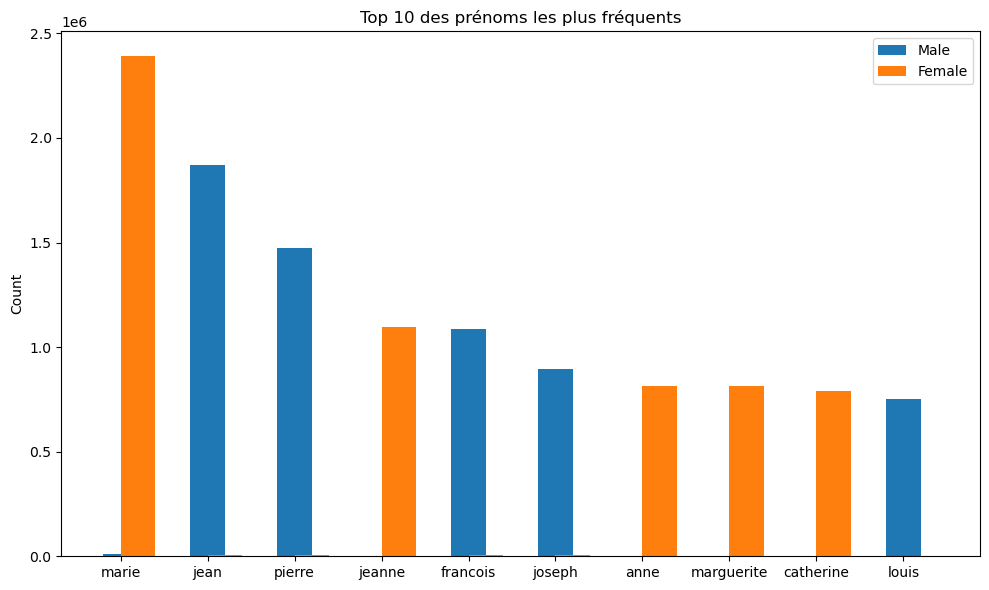

In [190]:
#Most frequent names
top_10 = name_sex.head(10) #Les données sont déjà dans l'ordre
fig, axes = plt.subplots(figsize=(10, 6)) 
axes.bar(top_10['firstname'], top_10['male'], width=0.4, align='center', label='Male')
axes.bar(top_10['firstname'], top_10['female'], width=0.4, align='edge', label='Female')
axes.set_title('Top 10 des prénoms les plus fréquents')
axes.set_ylabel('Count')
axes.legend()
plt.tight_layout() 
plt.savefig('Graphs/top10.jpg')
plt.show()

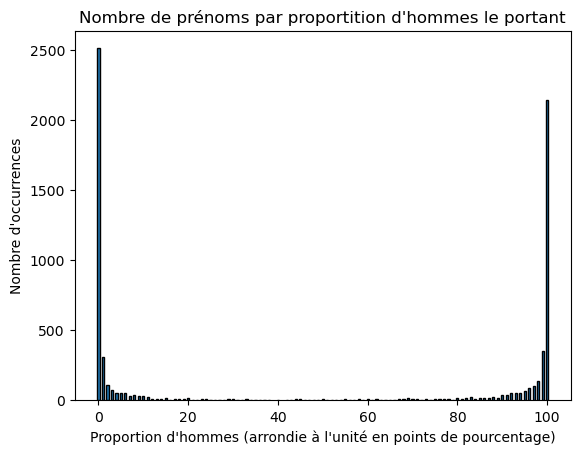

In [193]:
# Récupérer les valeurs de proportion_homme
proportion_homme_values = name_sex['prob_masc']*100
occurrences = proportion_homme_values.round().value_counts().sort_index() #Occurences

# Créer un histogramme
plt.bar(occurrences.index, occurrences.values, width=0.5, edgecolor='black')
plt.xlabel("Proportion d'hommes (arrondie à l'unité en points de pourcentage)")
plt.ylabel("Nombre d\'occurrences")
plt.title("Nombre de prénoms par proportition d'hommes le portant")
plt.savefig("Graphs/Nombre_hommes.jpg")
plt.show()

In [182]:
df = pd.read_csv('data/base.csv') #Importation
df

,firstname,prob_masc,prob_fem,sex,majo,occupation,link,employer,civil_status,observation
0,dominique,0.931546,0.068454,ambigu,homme,NaN,NaN,NaN,NaN,NaN
1,anonyme,0.695234,0.304766,ambigu,homme,NaN,NaN,NaN,NaN,NaN
2,camille,0.681515,0.318485,ambigu,homme,NaN,NaN,NaN,NaN,NaN
3,hyacinthe,0.611843,0.388157,ambigu,homme,NaN,NaN,NaN,NaN,NaN
4,modeste,0.288066,0.711934,ambigu,femme,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6949,petronille,0.002291,0.997709,femme,femme,sans,epouse,NaN,NaN,NaN
6950,alexandre,0.995444,0.004556,homme,homme,idem,son,NaN,NaN,NaN
6951,marguerite,0.001767,0.998233,femme,femme,idem,epouse,idem,NaN,NaN
6952,etienne,0.995768,0.004232,homme,homme,NaN,fils,NaN,NaN,NaN


In [135]:
df['prof_hf'] = df['prob_masc'] - df['prob_fem']
df
#The idea is that: if the value is near 1, it's masculine. If it's near -1, it's feminine. Near 0, it's ambiguous 

,firstname,prob_masc,prob_fem,sex,majo,occupation,link,employer,civil_status,observation,prof_hf
0,michel,0.996127,0.003873,homme,homme,NaN,NaN,NaN,NaN,NaN,0.992253
1,guillaume,0.996009,0.003991,homme,homme,NaN,NaN,NaN,NaN,NaN,0.992017
2,yves,0.996545,0.003455,homme,homme,NaN,NaN,NaN,NaN,NaN,0.993090
3,julien,0.995715,0.004285,homme,homme,NaN,NaN,NaN,NaN,NaN,0.991429
4,marianne,0.002083,0.997917,femme,femme,NaN,NaN,NaN,NaN,NaN,-0.995833
...,...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,femme,sans,epouse,NaN,NaN,NaN,-0.995419
6029,alexandre,0.995444,0.004556,homme,homme,idem,son,NaN,NaN,NaN,0.990888
6030,marguerite,0.001767,0.998233,femme,femme,idem,epouse,idem,NaN,NaN,-0.996465
6031,etienne,0.995768,0.004232,homme,homme,NaN,fils,NaN,NaN,NaN,0.991536


In [141]:
#We will create a database with some characteristics about names. 
# Nombre de lettres
df['firstname'] = df['firstname'].astype(str)

df['nb_lt'] = df['firstname'].apply(lambda x: len(x))
df['last_lt'] = df['firstname'].str[-1]
df['2last_lt'] = df['firstname'].str[-2:]
df['3last_lt'] = df['firstname'].str[-3:]

df

,firstname,prob_masc,prob_fem,sex,majo,occupation,link,employer,civil_status,observation,prof_hf,nb_lt,last_lt,2last_lt,3last_lt
0,michel,0.996127,0.003873,homme,homme,NaN,NaN,NaN,NaN,NaN,0.992253,6,l,el,hel
1,guillaume,0.996009,0.003991,homme,homme,NaN,NaN,NaN,NaN,NaN,0.992017,9,e,me,ume
2,yves,0.996545,0.003455,homme,homme,NaN,NaN,NaN,NaN,NaN,0.993090,4,s,es,ves
3,julien,0.995715,0.004285,homme,homme,NaN,NaN,NaN,NaN,NaN,0.991429,6,n,en,ien
4,marianne,0.002083,0.997917,femme,femme,NaN,NaN,NaN,NaN,NaN,-0.995833,8,e,ne,nne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,femme,sans,epouse,NaN,NaN,NaN,-0.995419,10,e,le,lle
6029,alexandre,0.995444,0.004556,homme,homme,idem,son,NaN,NaN,NaN,0.990888,9,e,re,dre
6030,marguerite,0.001767,0.998233,femme,femme,idem,epouse,idem,NaN,NaN,-0.996465,10,e,te,ite
6031,etienne,0.995768,0.004232,homme,homme,NaN,fils,NaN,NaN,NaN,0.991536,7,e,ne,nne


/tmp/ipykernel_262/3092396949.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['majo'] = df_model['majo'].replace({'homme': 1, 'femme': -1})
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.89



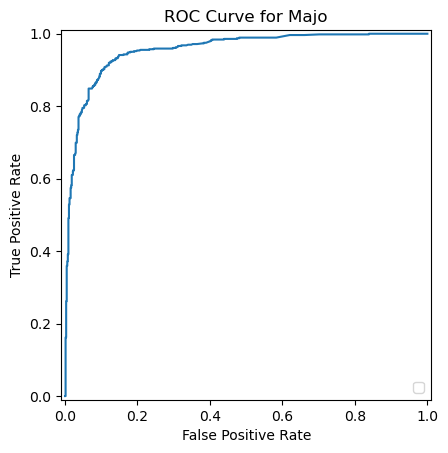

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve,ConfusionMatrixDisplay,RocCurveDisplay

df_model = df.drop(['firstname', 'sex', 'prof_hf', 'occupation', 'link', 'employer', 'civil_status', 'observation', 'prob_masc', 'prob_fem'], axis =1)
df_model['majo'] = df_model['majo'].replace({'homme': 1, 'femme': -1})
df_model = pd.get_dummies(df_model, columns=['last_lt', '2last_lt', '3last_lt'])
df_model = df_model.dropna()
X = df_model.drop(columns=['majo'])
y = df_model['majo']

#Split the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Create a Logistic Regression with the parameters found on Dataiku

model = LogisticRegression(penalty='l2', C=1, solver='saga')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

# Make predictions on the test set
y_pred = model.predict(X_test)

y_score = model.decision_function(X_test)
# Calculate the true positive rate and false positive rate for a range of thresholds
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title('ROC Curve for Majo')
plt.savefig('Graphs/ROC_majo.png')

/tmp/ipykernel_262/2716879582.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.89



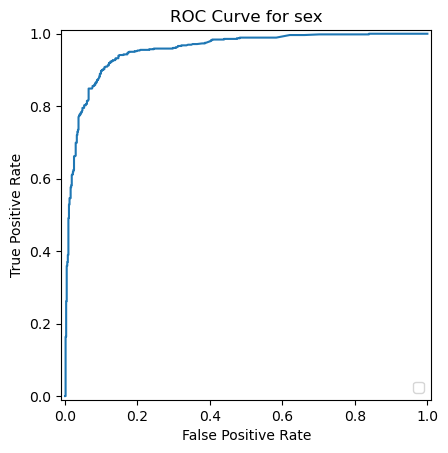

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve,ConfusionMatrixDisplay,RocCurveDisplay

df_model = df.drop(['firstname', 'majo', 'prof_hf', 'occupation', 'link', 'employer', 'civil_status', 'observation', 'prob_masc', 'prob_fem'], axis =1)
df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
df_model = pd.get_dummies(df_model, columns=['last_lt', '2last_lt', '3last_lt'])
df_model = df_model.dropna()
X = df_model.drop(columns=['sex'])
y = df_model['sex']

#Split the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Create a Logistic Regression with the parameters found on Dataiku

model = LogisticRegression(penalty='l2', C=1, solver='saga')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

# Make predictions on the test set
y_pred = model.predict(X_test)

y_score = model.decision_function(X_test)
# Calculate the true positive rate and false positive rate for a range of thresholds
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title('ROC Curve for sex')
plt.savefig('Graphs/ROC_sex.png')

In [143]:
from sklearn.model_selection import cross_val_score

for split in  [0.1, 0.2, 0.25, 0.33, 0.5]: 
    #Split the data into a train set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=1)

    model = LogisticRegression(penalty='l2', C=1, solver='saga')

    model.fit(X_train, y_train)

    scores = cross_val_score(model, X, y, cv=5)  # cv = nombre de plis pour la validation croisée

    print("Cross-Validation Scores:" + str(split), scores)


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Cross-Validation Scores:0.1 [0.90555095 0.90969345 0.90306545 0.90381426 0.90630182]


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Cross-Validation Scores:0.2 [0.90720795 0.90969345 0.90389395 0.90381426 0.90630182]


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Cross-Validation Scores:0.25 [0.90720795 0.90969345 0.90389395 0.90381426 0.90630182]


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Cross-Validation Scores:0.33 [0.90555095 0.90969345 0.90306545 0.90381426 0.90630182]


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:0.5 [0.90720795 0.90969345 0.90389395 0.90381426 0.90630182]


/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Faire un modèle qui prend que le prénom : majoritaire au lieu du seuil de 95\% défini préalablement 